In [2]:
import os
import numpy as np
import tensorflow as tf
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

import keras

from tensorflow.keras.layers import RandomTranslation, RandomZoom, RandomRotation

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Conv2D

import matplotlib.pyplot as plt
import seaborn as sns

import sys
from pathlib import Path

project_root = Path().resolve().parent
if not project_root in [Path(p).resolve() for p in sys.path]:
    sys.path.append(str(project_root))

from src import PATHS
from src.visualization.visualize import draw_spider_graph_dark, conf_matrix_dark

## Travail sur un échantilon

In [37]:
sample = pd.read_parquet(os.path.join(project_root,'data', 'metadata', 'samples', 'df_documents_sample_40k_1.parquet'), engine='fastparquet')

converted_prefix = os.path.join(project_root, 'data', 'converted')
sample['filepath'] = sample['rvl_image_path'].apply(lambda p: os.path.join(converted_prefix, p.replace("raw/", "").replace(".tif", ".jpg")))
sample = sample.drop(columns=['rvl_image_path', 'document_id', 'filename', 'iit_image_path', 'iit_individual_xml_path', 'iit_collective_xml_path'])

## Création des sets

In [38]:
# 1. Encodage des labels : pas besoin ? 
label_encoder = LabelEncoder()
sample['label_encoded'] = label_encoder.fit_transform(sample['label'])

# 2. On part de sample pour créer les différents sets
df_train = sample[sample['data_set'] == 'train']
df_val = sample[sample['data_set'] == 'val']
df_test = sample[sample['data_set'] == 'test']

# 3. Fonction pour charger et prétraiter une image
def process_image(file_path, label, augment=False):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image = preprocess_input(image)
    if augment:
        image = data_augmentation(image)
    return image, label

# 4. Création du dataset
def get_dataset(df_subset, shuffle=False, augment=False):
    file_paths = df_subset['filepath'].values
    labels = df_subset['label_encoded'].values
    dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    dataset = dataset.map(lambda x, y: process_image(x, y), num_parallel_calls=tf.data.AUTOTUNE)
    
    if shuffle:
        dataset = dataset.shuffle(buffer_size=1000)
    
    dataset = dataset.batch(32).prefetch(tf.data.AUTOTUNE)
    return dataset

train_ds = get_dataset(df_train, shuffle=True)
val_ds = get_dataset(df_val)
test_ds = get_dataset(df_test)

In [6]:
# Charger la base ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Geler les couches sauf 10
base_model.trainable = False
for layer in base_model.layers[-10:]:
    layer.trainable = True

# Construction du modèle
inputs = Input(shape=(224, 224, 3))

#On teste quelques augmentations: NON, ça donne des résultats mauvais
#x = tf.keras.layers.RandomRotation(0.02)(inputs)
#x = tf.keras.layers.RandomZoom(0.1)(x)
#x = tf.keras.layers.RandomContrast(0.1)(x)
#x = tf.keras.layers.RandomTranslation(0.05, 0.05)(x)

#on envoie tout ça dans le modèle
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(16, activation='softmax')(x)
model = Model(inputs, outputs)

# Compilation
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(patience=5, min_delta=0.001, verbose=1, monitor='val_loss', mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-6, verbose=1)
checkpoint = ModelCheckpoint('best_resnet_model.keras', monitor='val_loss', save_best_only=True, verbose=1)

# Entraînement
history_1 = model.fit(train_ds,
                      validation_data=val_ds,
                      epochs=10,
                      callbacks=[early_stopping, reduce_lr, checkpoint])

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step - accuracy: 0.4405 - loss: 1.8290  
Epoch 1: val_loss improved from inf to 1.12669, saving model to best_resnet_model.keras
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 563s 558ms/step - accuracy: 0.4406 - loss: 1.8287 - val_accuracy: 0.6571 - val_loss: 1.1267 - learning_rate: 1.0000e-04
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step - accuracy: 0.6683 - loss: 1.0802  
Epoch 2: val_loss improved from 1.12669 to 0.94473, saving model to best_resnet_model.keras
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 556s 556ms/step - accuracy: 0.6683 - loss: 1.0801 - val_accuracy: 0.7171 - val_loss: 0.9447 - learning_rate: 1.0000e-04
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step - accuracy: 0.7423 - loss: 0.8506  
Epoch 3: val_loss did not improve from 0.94473
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 555s 555ms/step - accuracy: 0.7424 - loss: 0.8505 - val_accuracy: 0.7323 - val_loss: 0.9474 - learning_rate: 1.0000e-04
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s

In [7]:
# On relance après avoir dégelé des couches (il y en a 177 en tout dans ResNet donc là on en dégèle 27 supplémentaires, soit 37

base_model.trainable = True
for layer in base_model.layers[:140]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history_2 = model.fit(train_ds,
                      validation_data=val_ds,
                      epochs=10,
                      callbacks=[early_stopping, reduce_lr, checkpoint])

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 654ms/step - accuracy: 0.6558 - loss: 1.2464   
Epoch 1: val_loss did not improve from 0.87914
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 718s 711ms/step - accuracy: 0.6559 - loss: 1.2461 - val_accuracy: 0.7438 - val_loss: 1.0256 - learning_rate: 1.0000e-05
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 648ms/step - accuracy: 0.8612 - loss: 0.4300   
Epoch 2: val_loss did not improve from 0.87914
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 705s 704ms/step - accuracy: 0.8613 - loss: 0.4299 - val_accuracy: 0.7638 - val_loss: 1.0493 - learning_rate: 1.0000e-05
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 649ms/step - accuracy: 0.9189 - loss: 0.2568   
Epoch 3: val_loss did not improve from 0.87914
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 705s 705ms/step - accuracy: 0.9189 - loss: 0.2568 - val_accuracy: 0.7638 - val_loss: 1.1352 - learning_rate: 1.0000e-05
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 647ms/step - accuracy: 0.9557 - loss: 0.1394   
Epoch 4: val_loss did not improve 

In [8]:
# encore une étape de dégelage, on rajoute 20 couches à entrainer 

for layer in base_model.layers[:120]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history_3 = model.fit(train_ds,
                      validation_data=val_ds,
                      epochs=10,
                      callbacks=[early_stopping, reduce_lr, checkpoint])

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 661ms/step - accuracy: 0.9874 - loss: 0.0438   
Epoch 1: val_loss did not improve from 0.87914
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 726s 719ms/step - accuracy: 0.9874 - loss: 0.0438 - val_accuracy: 0.7681 - val_loss: 1.3715 - learning_rate: 1.0000e-05
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 655ms/step - accuracy: 0.9883 - loss: 0.0371   
Epoch 2: val_loss did not improve from 0.87914
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 712s 712ms/step - accuracy: 0.9883 - loss: 0.0371 - val_accuracy: 0.7663 - val_loss: 1.4009 - learning_rate: 1.0000e-05
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 656ms/step - accuracy: 0.9913 - loss: 0.0289   
Epoch 3: val_loss did not improve from 0.87914
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 714s 713ms/step - accuracy: 0.9913 - loss: 0.0289 - val_accuracy: 0.7736 - val_loss: 1.4296 - learning_rate: 1.0000e-05
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 673ms/step - accuracy: 0.9922 - loss: 0.0267   
Epoch 4: val_loss did not improve 

In [9]:
def combine_histories(*histories):
    combined = {}
    for key in histories[0].history.keys():
        combined[key] = sum((h.history[key] for h in histories), [])
    return combined

combined_history = combine_histories(history_1, history_2, history_3)

In [10]:
# Save the best model
model.save(os.path.join(project_root,'models','ResNet50_best_30_epocs_sample_40_000_unfreeze_step_by_step.keras'))

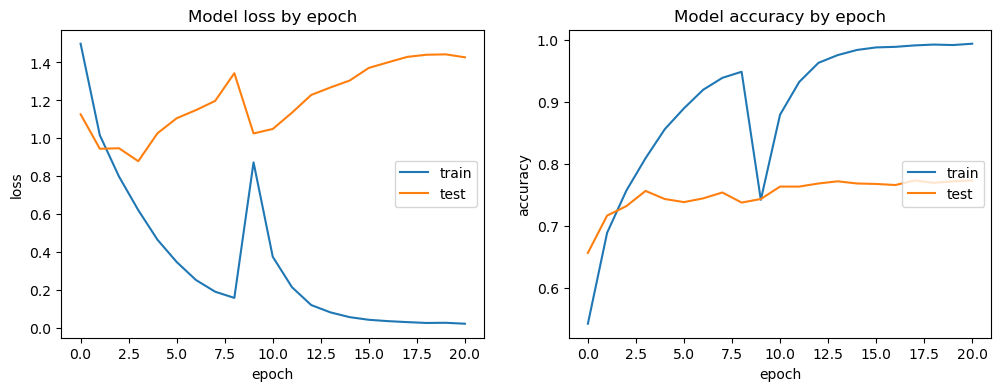

In [11]:
plt.figure(figsize=(12,4))

plt.subplot(121)
plt.plot(combined_history['loss'])
plt.plot(combined_history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')

plt.subplot(122)
plt.plot(combined_history['accuracy'])
plt.plot(combined_history['val_accuracy'])
plt.title('Model accuracy by epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')
plt.show()

In [4]:
model = keras.saving.load_model(os.path.join(project_root,'models','ResNet50_best_30_epocs_sample_40_000_unfreeze_step_by_step.keras'))

In [5]:
# Étape 1 : Prédire sur le test set
y_pred_probs = model.predict(test_ds)  # Probabilités
y_pred = np.argmax(y_pred_probs, axis=1)  # Classes prédites

# Étape 2 : Récupérer les vrais labels depuis le test set, dans le même ordre
y_true_check = []
for batch in test_ds:
    images, labels = batch
    y_true_check.extend(labels.numpy())

y_true = np.array(y_true_check)

# Étape 3 : Rapport de classification
print("\n Rapport de classification :")
print(classification_report(y_true, y_pred))



125/125 ━━━━━━━━━━━━━━━━━━━━ 114s 887ms/step

 Rapport de classification :
              precision    recall  f1-score   support

           0       0.74      0.75      0.75       246
           1       0.60      0.62      0.61       251
           2       0.89      0.97      0.93       252
           3       0.84      0.89      0.86       253
           4       0.81      0.84      0.82       251
           5       0.58      0.60      0.59       250
           6       0.88      0.86      0.87       257
           7       0.85      0.86      0.85       247
           8       0.85      0.89      0.87       253
           9       0.83      0.79      0.81       246
          10       0.72      0.70      0.71       250
          11       0.79      0.73      0.76       248
          12       0.63      0.69      0.66       249
          13       0.73      0.63      0.68       243
          14       0.89      0.89      0.89       254
          15       0.78      0.66      0.71       249

    a

In [8]:
cm = confusion_matrix(y_true, y_pred)
conf_matrix_dark(cm, "illustrations/ResNet_2_cm.png")

In [9]:
draw_spider_graph_dark(y_true, y_pred, save_path="illustrations/ResNet_2_spider.png")


Matrice de confusion :


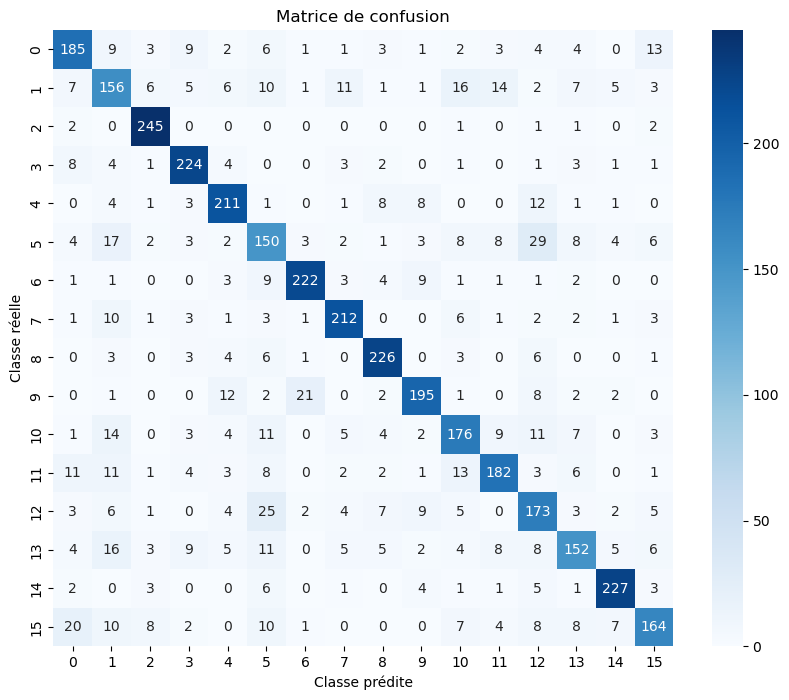

In [12]:
# Étape 4 : Matrice de confusion
print("Matrice de confusion :")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Matrice de confusion")
plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")
plt.show()

## représentations pour l'ancien model enregistré, sans step by step unfreeze

In [10]:
model_1 = keras.saving.load_model(os.path.join(project_root,'models','ResNet50_best_50_epocs_sample_40_000.keras'))

In [11]:
# Étape 1 : Prédire sur le test set
y_pred_probs_1 = model_1.predict(test_ds)  # Probabilités
y_pred_1 = np.argmax(y_pred_probs_1, axis=1)  # Classes prédites

# Étape 2 : Récupérer les vrais labels depuis le test set, dans le même ordre
y_true_check = []
for batch in test_ds:
    images, labels = batch
    y_true_check.extend(labels.numpy())

y_true = np.array(y_true_check)

# Étape 3 : Rapport de classification
print("\n Rapport de classification :")
print(classification_report(y_true, y_pred_1))



125/125 ━━━━━━━━━━━━━━━━━━━━ 111s 867ms/step

 Rapport de classification :
              precision    recall  f1-score   support

           0       0.74      0.70      0.72       246
           1       0.55      0.53      0.54       251
           2       0.93      0.87      0.90       252
           3       0.83      0.88      0.85       253
           4       0.86      0.84      0.85       251
           5       0.50      0.44      0.47       250
           6       0.88      0.82      0.85       257
           7       0.78      0.82      0.80       247
           8       0.81      0.91      0.86       253
           9       0.83      0.79      0.81       246
          10       0.64      0.66      0.65       250
          11       0.66      0.75      0.71       248
          12       0.61      0.63      0.62       249
          13       0.68      0.59      0.63       243
          14       0.84      0.86      0.85       254
          15       0.66      0.69      0.68       249

    a

In [12]:
cm_1 = confusion_matrix(y_true, y_pred_1)
conf_matrix_dark(cm_1, "illustrations/ResNet_1_cm.png")

In [13]:
draw_spider_graph_dark(y_true, y_pred_1, save_path="illustrations/ResNet_1_spider.png")


# degel progressif automatique: FAILED
Aucune idée pourquoi mais, dès le début, ça n'apprend pas, la loss ne fait qu'augmenter, et redescend par accoups au moment des dégels. 

In [39]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Charger la base ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Geler les couches sauf 10
base_model.trainable = False
for layer in base_model.layers[-10:]:
    layer.trainable = True

# Définir l’architecture complète
inputs = Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(16, activation='softmax')(x)  # 16 classes
model = Model(inputs, outputs)

# Compilation initiale
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [40]:
from tensorflow.keras.callbacks import Callback
import tensorflow.keras.backend as K

class SafeUnfreezeCallback(Callback):
    def __init__(self, base_model, model_path='best_model.keras',
                 unfreeze_step=5, max_unfreeze=30,
                 patience=5, min_delta=0.001):
        super().__init__()
        self.base_model = base_model
        self.model_path = model_path
        self.unfreeze_step = unfreeze_step
        self.max_unfreeze = max_unfreeze
        self.patience = patience
        self.min_delta = min_delta
        self.current_unfrozen = 10
        self.best_val_loss = float('inf')
        self.wait = 0
        self.trigger_reload = False

    def on_epoch_end(self, epoch, logs=None):
        val_loss = logs.get('val_loss')
        if val_loss is None:
            return

        if val_loss < self.best_val_loss - self.min_delta:
            self.best_val_loss = val_loss
            self.wait = 0
        else:
            self.wait += 1

        if self.wait >= self.patience and self.current_unfrozen < self.max_unfreeze:
            total_layers = len(self.base_model.layers)
            start = max(total_layers - self.current_unfrozen - self.unfreeze_step, 0)
            end = total_layers - self.current_unfrozen
            unfrozen = 0
            for layer in self.base_model.layers[start:end]:
                # Important : ne pas dégeler les BatchNormalization
                if not isinstance(layer, tf.keras.layers.BatchNormalization):
                    layer.trainable = True
                    unfrozen += 1

            self.current_unfrozen += unfrozen
            print(f"\n🔓 Dégel de {unfrozen} couches supplémentaires (total dégelées : {self.current_unfrozen})")

            # Réduction du learning rate
            old_lr = float(K.get_value(self.model.optimizer.learning_rate))
            new_lr = max(old_lr * 0.5, 1e-5)
            try:
                K.set_value(self.model.optimizer.learning_rate, new_lr)
            except AttributeError:
                print("⚠️ Impossible de modifier le learning rate — mauvais type. Recréation de l'optimiseur avec le nouveau LR.")
                self.model.compile(
                    optimizer=tf.keras.optimizers.Adam(learning_rate=new_lr),
                    loss=self.model.loss,
                    metrics=self.model.metrics,
                )
            print(f"📉 Nouveau learning rate : {old_lr:.2e} → {new_lr:.2e}")

            # Stop pour recharger le meilleur modèle
            print("⚠️ Entraînement interrompu → rechargement du meilleur modèle")
            self.model.stop_training = True
            self.trigger_reload = True

    def reset(self):
        self.wait = 0
        self.best_val_loss = float('inf')
        self.trigger_reload = False

In [41]:
early_stopping = EarlyStopping(patience=5, min_delta=0.001, monitor='val_loss', mode='min', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-6, verbose=1)
checkpoint = ModelCheckpoint('best_resnet_model.keras', monitor='val_loss', save_best_only=True, verbose=1)

# Initialisation de notre callback personnalisé
unfreeze_cb = SafeUnfreezeCallback(base_model=base_model,
                                   unfreeze_step=5,
                                   max_unfreeze=100,
                                   patience=5,
                                   min_delta=0.001)


In [42]:
max_rounds = 10  # Nombre maximal de phases d'entraînement
combined_history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}


for round_idx in range(max_rounds):
    print(f"\n🔁 Phase d'entraînement {round_idx + 1}")
    
    # 🔄 Réinitialise proprement le callback
    unfreeze_cb.reset()

    # Recharger le meilleur modèle
    model.load_weights('best_resnet_model.keras')
    model.compile(optimizer=tf.keras.optimizers.Adam(
                      learning_rate=float(K.get_value(model.optimizer.learning_rate))),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(train_ds,
                        validation_data=val_ds,
                        epochs=15,
                        callbacks=[unfreeze_cb, early_stopping, reduce_lr, checkpoint])

    # Combiner les historiques
    for key in combined_history:
        combined_history[key] += history.history.get(key, [])

    if not unfreeze_cb.trigger_reload:
        print("\n✅ Entraînement terminé — plus de couches à dégeler ou amélioration suffisante.")
        break



🔁 Phase d'entraînement 1
Epoch 1/15


C:\Users\lesca\anaconda3\envs\DL\Lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 50 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 599ms/step - accuracy: 0.8419 - loss: 0.5214  
Epoch 1: val_loss improved from inf to 0.95999, saving model to best_resnet_model.keras
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 671s 666ms/step - accuracy: 0.8419 - loss: 0.5213 - val_accuracy: 0.7561 - val_loss: 0.9600 - learning_rate: 1.0000e-04
Epoch 2/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 570ms/step - accuracy: 0.8848 - loss: 0.3726  
Epoch 2: val_loss did not improve from 0.95999
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 634s 634ms/step - accuracy: 0.8848 - loss: 0.3725 - val_accuracy: 0.7588 - val_loss: 1.0329 - learning_rate: 1.0000e-04
Epoch 3/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 564ms/step - accuracy: 0.9126 - loss: 0.2783  
Epoch 3: val_loss did not improve from 0.95999
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 626s 626ms/step - accuracy: 0.9127 - loss: 0.2783 - val_accuracy: 0.7508 - val_loss: 1.1432 - learning_rate: 1.0000e-04
Epoch 4/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 564ms/step - accuracy: 0.9324 - loss: 0.2098  
Epoch 4:

C:\Users\lesca\anaconda3\envs\DL\Lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 593ms/step - accuracy: 0.9032 - loss: 0.3137  
Epoch 1: val_loss improved from 0.95999 to 0.92481, saving model to best_resnet_model.keras
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 667s 661ms/step - accuracy: 0.9032 - loss: 0.3137 - val_accuracy: 0.7833 - val_loss: 0.9248 - learning_rate: 2.5000e-05
Epoch 2/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 590ms/step - accuracy: 0.9352 - loss: 0.2115  
Epoch 2: val_loss did not improve from 0.92481
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 656s 656ms/step - accuracy: 0.9352 - loss: 0.2115 - val_accuracy: 0.7886 - val_loss: 0.9795 - learning_rate: 2.5000e-05
Epoch 3/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 594ms/step - accuracy: 0.9563 - loss: 0.1423  
Epoch 3: val_loss did not improve from 0.92481
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 658s 658ms/step - accuracy: 0.9563 - loss: 0.1423 - val_accuracy: 0.7828 - val_loss: 1.0382 - learning_rate: 2.5000e-05
Epoch 4/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 593ms/step - accuracy: 0.9689 - loss: 0.0998  
Epoc

C:\Users\lesca\anaconda3\envs\DL\Lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 42 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 624ms/step - accuracy: 0.9362 - loss: 0.2001  
Epoch 1: val_loss improved from 0.92481 to 0.91211, saving model to best_resnet_model.keras
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 698s 692ms/step - accuracy: 0.9362 - loss: 0.2001 - val_accuracy: 0.7913 - val_loss: 0.9121 - learning_rate: 6.2500e-06
Epoch 2/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 617ms/step - accuracy: 0.9522 - loss: 0.1588  
Epoch 2: val_loss did not improve from 0.91211
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 682s 682ms/step - accuracy: 0.9522 - loss: 0.1587 - val_accuracy: 0.7908 - val_loss: 0.9420 - learning_rate: 6.2500e-06
Epoch 3/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 624ms/step - accuracy: 0.9610 - loss: 0.1306  
Epoch 3: val_loss did not improve from 0.91211
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 689s 689ms/step - accuracy: 0.9610 - loss: 0.1306 - val_accuracy: 0.7896 - val_loss: 0.9605 - learning_rate: 6.2500e-06
Epoch 4/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 615ms/step - accuracy: 0.9672 - loss: 0.1059  
Epoc

C:\Users\lesca\anaconda3\envs\DL\Lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 46 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 626ms/step - accuracy: 0.9531 - loss: 0.1564  
Epoch 1: val_loss did not improve from 0.91211
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 698s 692ms/step - accuracy: 0.9532 - loss: 0.1563 - val_accuracy: 0.7886 - val_loss: 0.9405 - learning_rate: 5.0000e-06
Epoch 2/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 611ms/step - accuracy: 0.9614 - loss: 0.1324  
Epoch 2: val_loss did not improve from 0.91211
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 675s 674ms/step - accuracy: 0.9615 - loss: 0.1324 - val_accuracy: 0.7891 - val_loss: 0.9445 - learning_rate: 5.0000e-06
Epoch 3/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 607ms/step - accuracy: 0.9677 - loss: 0.1095  
Epoch 3: val_loss did not improve from 0.91211
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 671s 671ms/step - accuracy: 0.9677 - loss: 0.1095 - val_accuracy: 0.7893 - val_loss: 0.9812 - learning_rate: 5.0000e-06
Epoch 4/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 611ms/step - accuracy: 0.9735 - loss: 0.0935  
Epoch 4: val_loss did not improve from 0.91211
10

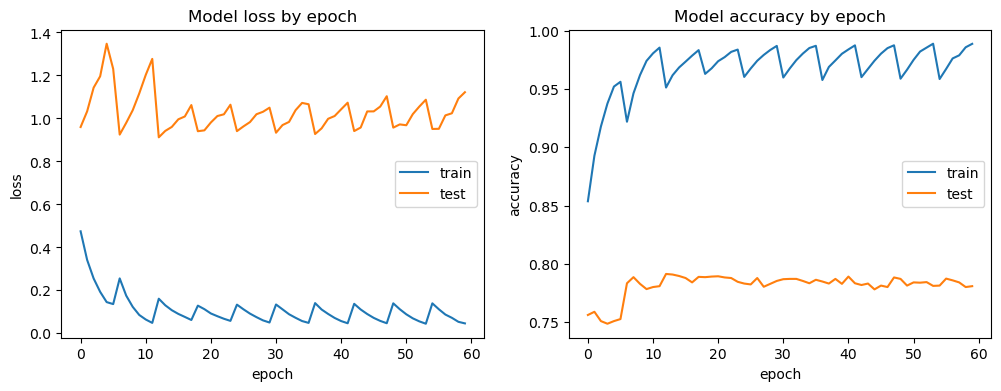

In [43]:
plt.figure(figsize=(12,4))

plt.subplot(121)
plt.plot(combined_history['loss'])
plt.plot(combined_history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')

plt.subplot(122)
plt.plot(combined_history['accuracy'])
plt.plot(combined_history['val_accuracy'])
plt.title('Model accuracy by epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')
plt.show()

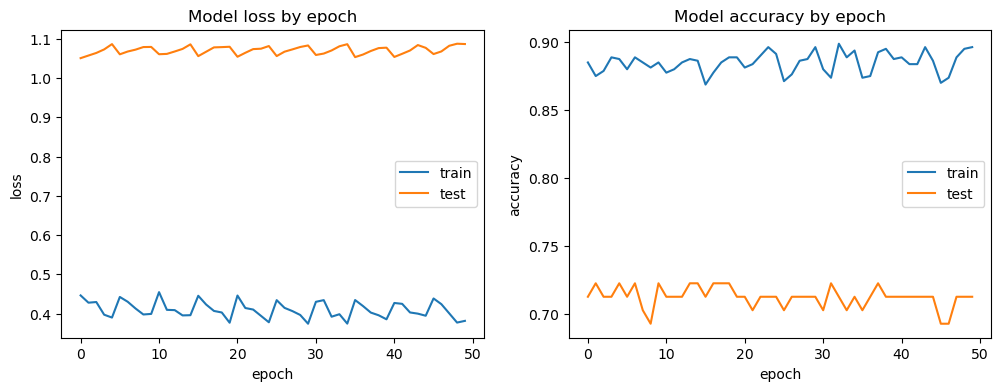

In [19]:
plt.figure(figsize=(12,4))

plt.subplot(121)
plt.plot(combined_history['loss'])
plt.plot(combined_history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')

plt.subplot(122)
plt.plot(combined_history['accuracy'])
plt.plot(combined_history['val_accuracy'])
plt.title('Model accuracy by epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')
plt.show()